The average of goals for the away team is: 1.187587168758717
The average of goals for the home team is: 1.745755783196268
-------------------------
The average of home team winning on non-neutral games is: 50.49194991055456
-------------------------
The country who scored the highest number of goals is: Zimbabwe with 518 goals
-------------------------
The teams with the most wins and goals is Germany. There is a really high correlation of 0.9887893978529124 between those two values. Hence they are the most likely to win a fifa event they enter, followed by brazil
-------------------------
Ttest_relResult(statistic=51.16172502338125, pvalue=0.0)
there is a small statistical difference on away goals and home goals. Results of a paired t test reveal a t-score of 1.16172502338125. While not enormous we should reject the null hypothesis. A paired test is needed since the data is related
-------------------------
Accuracy:  0.6534272901985907


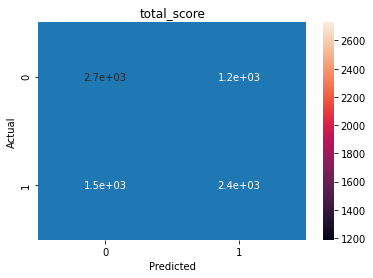

In [9]:
#  import libraries and read data
import pandas
import numpy as np
import datetime
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
df = pandas.read_csv("results.csv")

# --- Averages ---

print("The average of goals for the away team is:", df['away_score'].mean())
print("The average of goals for the home team is:" ,df['home_score'].mean())
print("-------------------------")
# --- total score histogram ---
df['total_score'] = df['away_score'] + df['home_score']
df.hist(column='total_score')
# --- home team’s win percentage ---

# add column based of home_team_won and away team won (to be used later in digital regression)
df['home_team_won'] = df['away_score'] < df['home_score']
df['away_team_won'] = df['home_score'] > df['away_score']

# subset of games played on non neutral locations
notNeutralVenuesGame = df[df['neutral'] == False]
# count the games won
homeTeamWonCount = notNeutralVenuesGame.home_team_won.sum()
# claculate proporton
homeTeamWonAverage = (homeTeamWonCount / notNeutralVenuesGame.home_team_won.size) * 100
print("The average of home team winning on non-neutral games is:", homeTeamWonAverage)
print("-------------------------")

# --- Country most goals fifa ---

# subset of fifa events. trim dataset in time, rename to score to later combine

# create date mask and filter out dates that don't fit
df['date'] = pandas.to_datetime(df['date'])  
mask = (df['date'] > datetime.datetime(2010, 1, 11)) & (df['date'] <= datetime.datetime.now())
fifaEvents = df.loc[mask]

# keep only FIFA events
fifaEvents = df[df['tournament'].str.contains("FIFA")]

# make two dataframes with scores by away and hpome countries
byCountriesHomeTeam = fifaEvents.groupby('home_team', as_index=False).agg({'home_score': 'sum'}).rename(columns={'home_score': 'score', 'home_team': 'team'})
byCountriesAwayTeam = fifaEvents.groupby('away_team', as_index=False).agg({'away_score': 'sum'}).rename(columns={'away_score': 'score', 'away_team': 'team'})

# concat and then sum the goals
totalByCountry = pandas.concat([byCountriesHomeTeam, byCountriesAwayTeam]).groupby('team', as_index=False).agg({'score' : 'sum'})
countryWithMostGoals = totalByCountry.max()
print("The country who scored the highest number of goals is:", countryWithMostGoals.team, "with", countryWithMostGoals.score, "goals")
print("-------------------------")




#  --- Strech goal: most likely to win fifa --- 



# select fifa events since 2005. Teams should have a bit changed but at least sample will be recent
df['date'] = pandas.to_datetime(df['date'])  
mask = (df['date'] > datetime.datetime(2005, 1, 11)) & (df['date'] <= datetime.datetime.now())
fifaEvents2005 = df.loc[mask]
fifaEvents2005 = df[df['tournament'].str.contains("FIFA")]

# calculate top 30 countries with the most goals
byCountriesHomeTeam = fifaEvents2005.groupby('home_team', as_index=False).agg({'home_score': 'sum'}).rename(columns={'home_score': 'score', 'home_team': 'team'})
byCountriesAwayTeam = fifaEvents2005.groupby('away_team', as_index=False).agg({'away_score': 'sum'}).rename(columns={'away_score': 'score', 'away_team': 'team'})

totalGoalsByCountry = pandas.concat([byCountriesHomeTeam, byCountriesAwayTeam]).groupby('team', as_index=False).agg({'score' : 'sum'}).sort_values(by='score',ascending=False)

# calculate top 30 wins for countries
def parse_winner(x):
    if x["home_score"] > x["away_score"]:
       return x["home_team"]
    elif x["home_score"]< x["away_score"]:
       return x["away_team"]
    else:
        return "draw"

fifaEvents2005['winning_team'] = fifaEvents2005.apply(lambda row: parse_winner(row), axis=1)
totalWinsByCountry = fifaEvents2005[fifaEvents2005['winning_team'] != 'draw']['winning_team'].value_counts().rename_axis('team').reset_index(name='wins')


# merge together wins and score based and sort them on both columns
byWinsAndScores = pandas.merge(totalGoalsByCountry, totalWinsByCountry, on="team").sort_values(['score', 'wins'], ascending=[False, False])
winScoreCorrelation = byWinsAndScores['score'].corr(byWinsAndScores['wins'])
teamWithMostChanges = byWinsAndScores.iloc[0]['team']

print(f'The teams with the most wins and goals is {teamWithMostChanges}. There is a really high correlation of {winScoreCorrelation} between those two values. Hence they are the most likely to win a fifa event they enter, followed by brazil')
print("-------------------------")

#  --- Strech goal: statistical difference between home and away score ---

# to see if there is an impact we need to calculate on non neutral venues.
rel = ttest_rel(notNeutralVenuesGame['home_score'], notNeutralVenuesGame['away_score'])
print(rel)
print(f'there is a small statistical difference on away goals and home goals. Results of a paired t test reveal a t-score of 51.16172502338125. While not enormous we should reject the null hypothesis. A paired test is needed since the data is related')
print("-------------------------")


#  Super stretch: Logistic regression
#  moel is meant to calculate on location so we will keep only non neutral games

# step 1 calculate ods of away team wins
odsHomeTeamWins = notNeutralVenuesGame.groupby('home_team', as_index=False).agg({'home_team_won': 'mean'})
odsHomeTeamWins['home_team_won'] = odsHomeTeamWins['home_team_won'] / (1 - odsHomeTeamWins['home_team_won'])
odsHomeTeamWins.columns = ['home_team', 'home_ods']

# step 2 calculate ods of 
odsAwayTeamWins = notNeutralVenuesGame.groupby('away_team', as_index=False).agg({'away_team_won': 'mean'})
odsAwayTeamWins['away_team_won'] = odsAwayTeamWins['away_team_won'] / (1 - odsAwayTeamWins['away_team_won'])
odsAwayTeamWins.columns = ['away_team', 'away_ods']

# step 3 get back the ods and into the original dataframe
notNeutralVenuesGameWithOds = pandas.merge(notNeutralVenuesGame, odsHomeTeamWins, on="home_team")
notNeutralVenuesGameWithOds = pandas.merge(notNeutralVenuesGameWithOds, odsAwayTeamWins, on="away_team")
notNeutralVenuesGameWithOds.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# step 4 clean of inf and drop NA
notNeutralVenuesGameWithOds = notNeutralVenuesGameWithOds.replace([np.inf, -np.inf], np.nan).dropna()

# step 4 home_team_won -> one hot encoded feature
notNeutralVenuesGameWithOds['home_team_won'] = notNeutralVenuesGameWithOds['home_team_won'].replace({True: 1, False: 0})

# create the logistic regression
X = notNeutralVenuesGameWithOds[['away_ods', 'home_ods']]
y = notNeutralVenuesGameWithOds['home_team_won']

# we will train on 75% of the model and keep 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pandas.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()